<a href="https://colab.research.google.com/github/pawangoyal137/RNN_and_LSTM/blob/master/Copy_of_Copy_of_6864_hw2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
rm -rf 6864-hw2
git clone https://github.com/lingo-mit/6864-hw2.git

In [0]:
import sys
sys.path.append("/content/6864-hw2")

import numpy as np
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn
from sklearn.metrics import precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"

# **Introduction**

In this lab, you will explore two types of recurrent architectures to perform sequential classification. Specifically, you are asked to implement and train a vanilla RNN (no gate mechanism) and an LSTM for the task of Name Entity Recognition (NER). For details about NER, you can read [this](https://en.wikipedia.org/wiki/Named-entity_recognition) wikipage.

To complete this lab, you need to first understand the recurrent update equations introduced in lecture, and transform them into PyTorch code.

In NER, your task is to predict the correct name entity of each word in a sentence.
We are going to work with a dataset called MIT-Restaurants. We've helped you preprocessed the data. They now look like this:

In [0]:
def read_file(f_name):
    data = []
    with open(f_name, 'r') as f:
        for line in f:
            data.append(line.strip().split())
    return data

train_data = read_file('/content/6864-hw2/train.dat')
train_tags = read_file('/content/6864-hw2/train.tag')

test_data = read_file('/content/6864-hw2/test.dat')
test_tags = read_file('/content/6864-hw2/test.tag')

print('Total amount of training samples: %d' % len(train_data))
print('Total amount of testing samples: %d' % len(test_data))
print('Average sentence length in training data: %f' % (
    np.mean([len(sent) for sent in train_data])))

print('\nExample:')
print('The first sentence is: ' + str(train_data[:4]))
print('Its corresponding name entity sequence is: ' + str(train_tags[:4]))

Total amount of training samples: 7660
Total amount of testing samples: 1521
Average sentence length in training data: 9.206919

Example:
The first sentence is: [['2', 'start', 'restaurants', 'with', 'inside', 'dining'], ['34'], ['5', 'star', 'resturants', 'in', 'my', 'town'], ['98', 'hong', 'kong', 'restaurant', 'reasonable', 'prices']]
Its corresponding name entity sequence is: [['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity'], ['O'], ['B-Rating', 'I-Rating', 'O', 'B-Location', 'I-Location', 'I-Location'], ['O', 'B-Restaurant_Name', 'I-Restaurant_Name', 'O', 'B-Price', 'O']]


Here are some helper functions and more data preprocessing before we move on to implementing our models. No code to write in this section but please do understand it as some variables defined here will be used later for training and evaluation. 

In [0]:
# From train data, collect all unique word types as a set and add 'UNK' to it.
# Unseen words in test data will be turned into 'UNK'.
vocab_set = list(set([word for sent in train_data for word in sent])) + ['UNK']
num_vocabs = len(vocab_set)
print("Number of word types, including 'UNK': %d" % num_vocabs)

# Assign each word type an unique id.
vocab2id = {v : i for i, v in enumerate(vocab_set)}


# We also collect all tag (class) types and assign an unique id to each of them.
# There won't be unseen tag type in test data.
tag_set = list(set([tag for tag_seq in train_tags for tag in tag_seq]))
num_tags = len(tag_set)
print("Number of tag types: %d" % num_tags)
print('These are the tag types: ' + str(tag_set))

tag2id = {t : i for i, t in enumerate(tag_set)}
# Inverse dictionary of tag2id, you will need this during evaluation!
id2tag = {i : t for t, i in tag2id.items()}

Number of word types, including 'UNK': 3805
Number of tag types: 17
These are the tag types: ['I-Rating', 'B-Hours', 'I-Price', 'I-Location', 'B-Dish', 'B-Location', 'B-Price', 'I-Restaurant_Name', 'I-Amenity', 'I-Dish', 'O', 'B-Rating', 'B-Restaurant_Name', 'B-Cuisine', 'I-Cuisine', 'I-Hours', 'B-Amenity']


Now that you have understood what raw data look like, it's your turn to transform them into the format that our model actually takes as input: one-hot encoding. Hint: in tag_to_id function, the B-I-O refers to beginning, inside and outside. Each of them means the beginning of the tagging chunk, inside the tagging chunk and outside the tagging chunk. For more detailed explanation, please refer to the IOB2 format in [this](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) wikipage.

In [0]:
def one_hot_encoding(sent, vocab2id):
    # Example input `sent` (a list of words):
    # ['2', 'start', 'restaurants', 'with', 'inside', 'dining']

    one_hot = torch.zeros(len(sent), len(vocab2id))
    for i,word in enumerate(sent):
      if word in vocab2id:
        one_hot[i][vocab2id[word]] = 1
      else:
        one_hot[i][vocab2id['UNK']] = 1

    return one_hot


def tag_to_id(tag_seq, tag2id):
    # Example input `tag_seq` (a list of tags):
    # ['B-Rating', 'I-Rating', 'O', 'O', 'B-Amenity', 'I-Amenity']

    id_seq = torch.zeros(len(tag_seq), dtype=torch.long)
    for i,tag in enumerate(tag_seq):
      id_seq[i] = tag2id[tag]

    return id_seq


# Apply one-hot encoding to data.
train_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in train_data]
# Transform tag names into ids.
train_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in train_tags]

# train_data_oh_list should now be a list of 2d-tensors, each has shape (sent_len, num_vocabs)
# Note that to utilize the `shape` attribute, each element in the list should
# already be a torch tensor.
print("First sentence has shape: %s" % str(train_data_oh_list[0].shape))
print("Fifth sentence has shape: %s" % str(train_data_oh_list[4].shape))
# train_tags_id_list is a list of 1d-tensors, each that has shape (sent_len,)
print("first tag sequence has shape: %s" % train_tags_id_list[0].shape)
print("Fifth tag sequence has shape: %s" % train_tags_id_list[4].shape)


# Apply same conversion to test dataset.
test_data_oh_list = [one_hot_encoding(sent, vocab2id) for sent in test_data]
test_tags_id_list = [tag_to_id(tag_seq, tag2id) for tag_seq in test_tags]

First sentence has shape: torch.Size([6, 3805])
Fifth sentence has shape: torch.Size([12, 3805])
first tag sequence has shape: 6
Fifth tag sequence has shape: 12


# **Part 1: Recurrent Neural Network (RNN)**

In this part, you will implement a vanilla RNN. You are not allowed to use the PyTorch built-in RNN/RNNCell modules--you will have to implement the update rules yourself. Please follow the formulation introduced in lecture.

In [0]:
class RNN(nn.Module):
    # A torch module implementing an RNN. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        # `input_size`, `hidden_size`, and `output_size` are all int.

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # self.Whh= nn.Parameter(torch.randn(self.hidden_size,self.hidden_size, device=device))
        # self.Wxh=nn.Parameter(torch.randn(self.hidden_size,self.input_size, device=device))
        # self.Why=nn.Parameter(torch.randn(self.output_size,self.hidden_size, device=device))
        # self.Bh=nn.Parameter(torch.randn(self.hidden_size,1, device=device))
        # self.By=nn.Parameter(torch.randn(self.output_size,1, device=device))
        self.Whh = nn.Linear(self.hidden_size,self.hidden_size)
        self.Wxh = nn.Linear(self.input_size,self.hidden_size,bias = False)
        self.Why = nn.Linear(self.hidden_size,self.output_size)
        # Your code here!


    def forward(self, input, hidden):
        # `input` is a 2d-tensor of shape (1, input_size); `hidden` is another
        # 2d-tensor of shape (1, hidden_size), representing the hidden state of
        # the previous time step.

        # output = torch.zeros(1, self.output_size)
        hidden = torch.tanh(self.Whh(hidden)+self.Wxh(input))
        output = self.Why(hidden)
        # print(self.hidden_size,self.output_size)
        # print(hidden.shape,output.shape)
        return output, hidden

    def initHidden(self):
        # Use to initialize hidden state everytime before running a sentence.
        return torch.zeros(1, self.hidden_size)

Now that you have defined your RNN model, we can start training it. We've provided the main training loop, but you will have to implement the fucntion `rnn_train_one_sample`, which takes a (sentence-tensor, tag-tensor)-pair as input and does one step of gradient update. To understand better what this function is supposed to do, you can go over the main training loop in the next section first.

In [0]:
learning_rate = 1e-3
rnn_hidden_size = 128

rnn_model = RNN(input_size=num_vocabs, hidden_size=rnn_hidden_size,
                output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
# print(list(rnn_model.parameters()))
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
print(sum(p.numel() for p in rnn_model.parameters() if p.requires_grad))

def rnn_train_one_sample(model, sent_tensor, tag_tensor):
    # Run through a sentence, generate output, compute loss, and perform one
    # gradient update. Sentence and tag are represented as a 2d-tensor
    # `sent_tensor` and a 1d-tensor `tag_tensor`, respectively.

    # Initialize hidden state.
    hidden = model.initHidden().to(device)
    outputs=[]
    n,d = sent_tensor.shape
    for i in range(n):
      output,hidden = model.forward(sent_tensor[i:i+1,:],hidden)
      outputs.append(output)

    outputs = torch.cat(outputs, 0)
    loss = criterion(outputs, tag_tensor)

    rnn_optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 5)
    rnn_optimizer.step()

    return outputs, loss.item()

505745


Here's the main training loop for training RNN:

In [0]:


n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []
grad_Whh = []
grad_Wxh = []
grad_Why = []
current_grad_Whh = 0
current_grad_Wxh = 0
current_grad_Why = 0


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

rnn_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = rnn_train_one_sample(rnn_model, sent_tensor, tag_tensor)
        current_loss += loss
        # print(float(torch.norm(rnn_model.Whh.weight.grad)))
        current_grad_Whh += float(torch.norm(rnn_model.Whh.weight.grad, 2))
        current_grad_Wxh += float(torch.norm(rnn_model.Wxh.weight.grad, 2))
        current_grad_Why += float(torch.norm(rnn_model.Why.weight.grad, 2))


        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))
            print(float(torch.norm(rnn_model.Whh.weight.grad, 2)))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            grad_Whh.append(current_grad_Whh / plot_every)
            current_grad_Whh = 0
            grad_Wxh.append(current_grad_Wxh / plot_every)
            current_grad_Wxh = 0
            grad_Why.append(current_grad_Why / plot_every)
            current_grad_Why = 0

        iter_count += 1

Now let's plot the learning curve. The x-axis is the training iterations and the y-axis is the training loss. The loss should be going down.

Text(0, 0.5, 'Gradient')

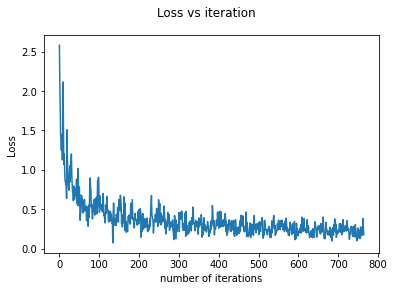

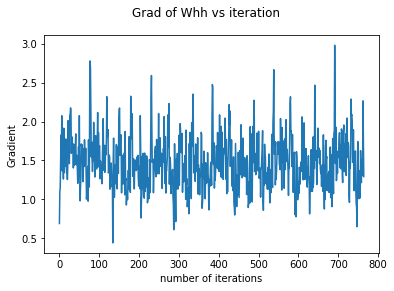

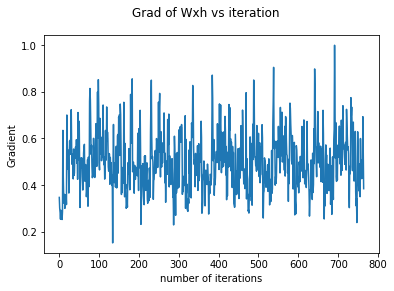

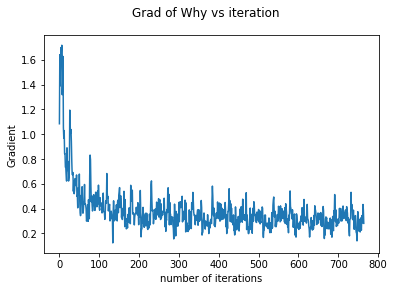

In [0]:

fig = plt.figure()
plt.plot(all_losses)
fig.suptitle('Loss vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Loss')

fig = plt.figure()
plt.plot(grad_Whh)
fig.suptitle('Grad of Whh vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Wxh)
fig.suptitle('Grad of Wxh vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Why)
fig.suptitle('Grad of Why vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')



Now that we have trained our RNN, it's time to evaluate it on the test set.

In [0]:
# Evaluation

import sklearn
from sklearn.metrics import precision_recall_fscore_support


def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)


# Make prediction for one sentence.
def rnn_predict_one_sent(model, sent_tensor):
    hidden = model.initHidden().to(device)


    outputs=[]
    n,d = sent_tensor.shape
    for i in range(n):
      output,hidden = model.forward(sent_tensor[i:i+1,:],hidden)
      outputs.append(output)

    outputs = torch.cat(outputs, 0)
    predicted_tag_id = torch.argmax(outputs,dim = 1)
    # print(predicted_tag_id.shape)
    # print(outputs.shape)
    # print(predicted_tag_id)
    return predicted_tag_id


rnn_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = rnn_predict_one_sent(rnn_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7459463901036695, 0.750862620366039, 0.741378467974944)

# **Part 2: Long Short-Term Memory (LSTM)**

In part 2, you will implement your own LSTM. Same in part 1, you are not allowed to use PyTorch built-in LSTM/LSTMCell modules. For reference, you can look up the wikipage for the [LSTM architecture](https://en.wikipedia.org/wiki/Long_short-term_memory).

In [0]:

class LSTM(nn.Module):
    # A torch module implementing an LSTM. The `forward` function should just
    # perform one step of update and output logits before softmax.

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.Whi = nn.Linear(self.hidden_size,self.hidden_size)
        self.Wxi = nn.Linear(self.input_size,self.hidden_size,bias = False)
        self.Whf = nn.Linear(self.hidden_size,self.hidden_size)
        self.Wxf = nn.Linear(self.input_size,self.hidden_size,bias = False)
        self.Who = nn.Linear(self.hidden_size,self.hidden_size)
        self.Wxo = nn.Linear(self.input_size,self.hidden_size,bias = False)
        self.Whh = nn.Linear(self.hidden_size,self.hidden_size)
        self.Wxh = nn.Linear(self.input_size,self.hidden_size,bias = False)
        self.Why = nn.Linear(self.hidden_size,self.output_size)



    def forward(self, input, hidden, memory):
        # `input` is a 2d-tensor of shape (1, input_size);
        # `hidden` and `memory` are both 2d-tensors of shape (1, hidden_size),
        # representing the hidden and memory states of the previous time step.
        i = torch.sigmoid(self.Whi(hidden)+self.Wxi(input))
        f = torch.sigmoid(self.Whf(hidden)+self.Wxf(input))
        o = torch.sigmoid(self.Who(hidden)+self.Wxo(input))
        c = torch.tanh(self.Whh(hidden)+self.Wxh(input))
        memory = f*memory+i*c
        hidden = o*torch.tanh(memory)
        output = self.Why(hidden)
        # Your code here!

        return output, hidden, memory

    def initHidden(self):
        # Initialize hidden and memory states.
        return (torch.zeros(1, self.hidden_size),
                torch.zeros(1, self.hidden_size))

Same with part 1, we provide the main training loop for training LSTM, but you will need to implement the `lstm_train_one_sample` function, and also apply gradient clipping.

In [0]:
learning_rate = 1e-3
lstm_hidden_size = 128 #originally it was 128

lstm_model = LSTM(input_size=num_vocabs, hidden_size=lstm_hidden_size,
                  output_size=num_tags).to(device)

criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(),  lr=learning_rate)
# 505745 parameters in RNN

print(sum(p.numel() for p in lstm_model.parameters() if p.requires_grad))

def lstm_train_one_sample(model, sent_tensor, tag_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    # Your code here!

    outputs=[]
    n,d = sent_tensor.shape
    for i in range(n):
      output,hidden,memory = lstm_model.forward(sent_tensor[i:i+1,:],hidden,memory)
      # print(output.shape,hidden.shape,memory.shape)
      outputs.append(output)

    # print(len(outputs),outputs[0].shape)
    outputs = torch.cat(outputs, 0)
    # print(n,d,outputs.shape,tag_tensor.shape)
    loss = criterion(outputs, tag_tensor)

    lstm_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), max_norm = 5)
    lstm_optimizer.step()

    return outputs, loss.item()

2016401


LSTM main training loop:

In [0]:
n_epochs = 5
iter_count = 0
print_every = 1000
plot_every = 50

# Keep track of losses for plotting
current_loss = 0
all_losses = []
grad_Whi = []
grad_Wxi = []
grad_Whf = []
grad_Wxf = []
grad_Who = []
grad_Wxo = []
grad_Whh = []
grad_Wxh = []
grad_Why = []
current_grad_Whi = 0
current_grad_Wxi = 0
current_grad_Whf = 0
current_grad_Wxf = 0
current_grad_Who = 0
current_grad_Wxo = 0
current_grad_Whh = 0
current_grad_Wxh = 0
current_grad_Why = 0

start = time.time()


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

lstm_model.train()
for epoch_i in range(n_epochs):
    for sent_tensor, tag_tensor in zip(train_data_oh_list, train_tags_id_list):
        sent_tensor = sent_tensor.to(device)
        tag_tensor = tag_tensor.to(device)
  
        output, loss = lstm_train_one_sample(lstm_model, sent_tensor, tag_tensor)
        current_loss += loss
        current_grad_Whi += float(torch.norm(lstm_model.Whi.weight.grad, 2))
        current_grad_Wxi += float(torch.norm(lstm_model.Wxi.weight.grad, 2))
        current_grad_Whf += float(torch.norm(lstm_model.Whf.weight.grad, 2))
        current_grad_Wxf += float(torch.norm(lstm_model.Wxf.weight.grad, 2))
        current_grad_Who += float(torch.norm(lstm_model.Who.weight.grad, 2))
        current_grad_Wxo += float(torch.norm(lstm_model.Wxo.weight.grad, 2))
        current_grad_Whh += float(torch.norm(lstm_model.Whh.weight.grad, 2))
        current_grad_Wxh += float(torch.norm(lstm_model.Wxh.weight.grad, 2))
        current_grad_Why += float(torch.norm(lstm_model.Why.weight.grad, 2))


        if iter_count % print_every == 0:
            print('%d %s %.4f' % (iter_count, timeSince(start), loss))

        # Add current loss avg to list of losses
        if iter_count % plot_every == 0 and iter_count > 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            grad_Whi.append(current_grad_Whi / plot_every)
            current_grad_Whi = 0
            grad_Wxi.append(current_grad_Wxi / plot_every)
            current_grad_Wxi = 0
            grad_Whf.append(current_grad_Whf / plot_every)
            current_grad_Whf = 0
            grad_Wxf.append(current_grad_Wxf / plot_every)
            current_grad_Wxf = 0
            grad_Who.append(current_grad_Who / plot_every)
            current_grad_Who = 0
            grad_Wxo.append(current_grad_Wxo / plot_every)
            current_grad_Wxo = 0
            grad_Whh.append(current_grad_Whh / plot_every)
            current_grad_Whh = 0
            grad_Wxh.append(current_grad_Wxh / plot_every)
            current_grad_Wxh = 0
            grad_Why.append(current_grad_Why / plot_every)
            current_grad_Why = 0

        iter_count += 1

Text(0, 0.5, 'Gradient')

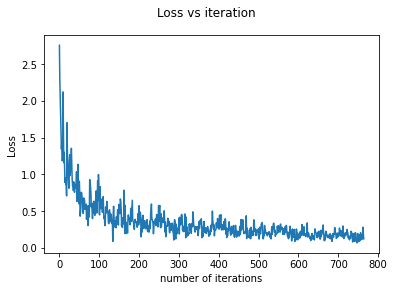

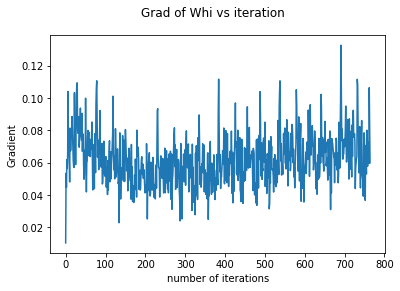

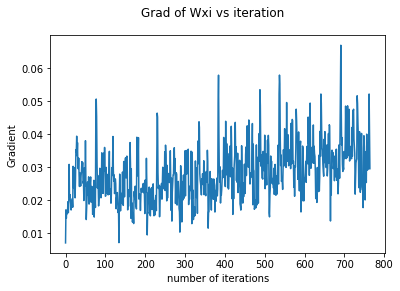

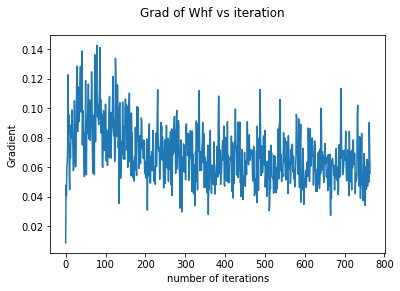

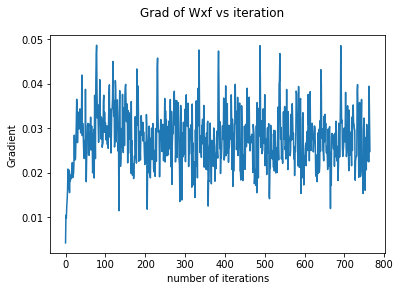

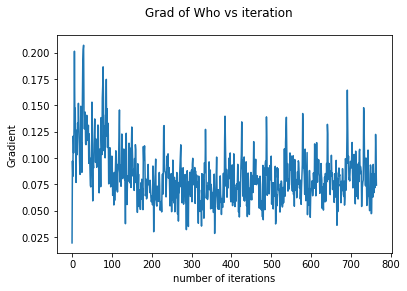

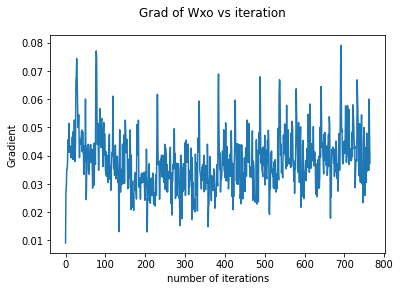

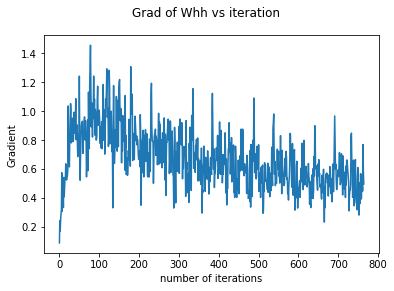

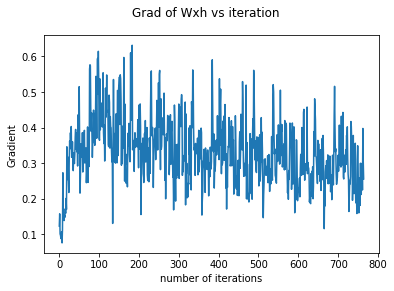

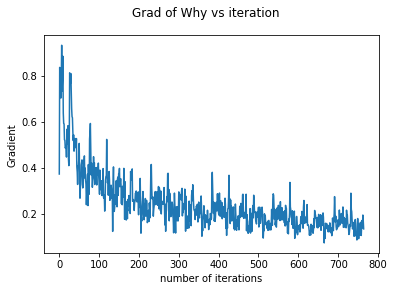

In [0]:
fig = plt.figure()
plt.plot(all_losses)
fig.suptitle('Loss vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Loss')

fig = plt.figure()
plt.plot(grad_Whi)
fig.suptitle('Grad of Whi vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Wxi)
fig.suptitle('Grad of Wxi vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Whf)
fig.suptitle('Grad of Whf vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Wxf)
fig.suptitle('Grad of Wxf vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Who)
fig.suptitle('Grad of Who vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Wxo)
fig.suptitle('Grad of Wxo vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Whh)
fig.suptitle('Grad of Whh vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Wxh)
fig.suptitle('Grad of Wxh vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')

fig = plt.figure()
plt.plot(grad_Why)
fig.suptitle('Grad of Why vs iteration')
plt.xlabel('number of iterations')
plt.ylabel('Gradient')


Now let's evaluate our LSTM model.

In [0]:
def evaluate_result(true_tag_list, predicted_tag_list):
    # Example: true_tag_list/predicted_tag_list:
    #   [[‘O’, ‘O’, ‘I’, ‘N’, ...]
    #    [‘I’, ‘I’, ‘O’, ‘N’, ...]],
    # each sublist corresponds to an input sentence.
    p_list = []
    r_list = []
    f1_list = []
    for true_tag, predicted_tag in zip(true_tag_list, predicted_tag_list):
        p, r, f1, _ = precision_recall_fscore_support(true_tag, predicted_tag,
                                                      average='macro',
                                                      zero_division=0)
        p_list.append(p)
        r_list.append(r)
        f1_list.append(f1)
    return np.mean(p_list), np.mean(r_list), np.mean(f1_list)
    
def lstm_predict_one_sent(model, sent_tensor):
    hidden, memory = model.initHidden()
    hidden = hidden.to(device)
    memory = memory.to(device)
    outputs=[]
    n,d = sent_tensor.shape
    for i in range(n):
      output,hidden,memory = model.forward(sent_tensor[i:i+1,:],hidden,memory)
      outputs.append(output)

    outputs = torch.cat(outputs, 0)
    predicted_tag_id = torch.argmax(outputs,dim = 1)
    # print(predicted_tag_id.shape)
    # print(outputs.shape)
    # print(predicted_tag_id)

    return predicted_tag_id


lstm_model.eval()
predicted_tags = []
for sent_tensor in test_data_oh_list:
    sent_tensor = sent_tensor.to(device)
    predicted_tag_id = lstm_predict_one_sent(lstm_model, sent_tensor)
    predicted_tags.append([id2tag[idx] for idx in predicted_tag_id.detach().cpu().numpy()])

# Will output precision, recall, and f1 score.
evaluate_result(test_tags, predicted_tags)

(0.7699173906929612, 0.7752402987774651, 0.7664771882870984)